<a href="https://colab.research.google.com/github/rpast/t-sunset/blob/main/tsunset_finetuning_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jan 23 19:03:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.5 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
## Import section ##
####################
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("no CUDA!")

In [15]:
#load dataset
dset = pd.read_csv('./drive/MyDrive/datasets/the-office_lines.csv')

dset_n = dset[['Character', 'Line']].copy()

# form inputs feature
dset_n['inputs'] = "CHARACTER: " + dset_n['Character'] + "; LINE: " + dset_n['Line']

dset_main = dset_n['inputs']

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


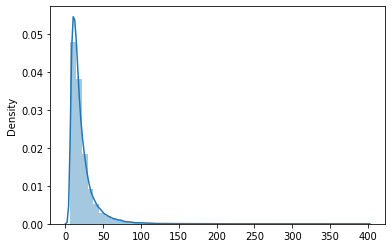

In [16]:
doc_lengths = []

for line in dset_main:

    # get rough token count distribution
    tokens = nltk.word_tokenize(line)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [17]:
np.average(doc_lengths)

21.46605132746377

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [14]:
batch_size = 2

In [18]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [19]:
dataset = GPT2Dataset(dset_main, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # << TRAIN DSET

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

52,848 training samples
5,873 validation samples


In [20]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [21]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [22]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [26]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)


for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  26,424. Loss: 0.06609563529491425.   Elapsed: 0:00:52.
0:  bipartisanCHARACTER: Dwight; LINE:  I’m still trying to keep myself in a boat with an Asian woman I’m going to take out of the boat with an Asian woman I’m going to take out of the boat with my assistant.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  26,424. Loss: 0.046413224190473557.   Elapsed: 0:01:44.
0:  increasingCHARACTER: Pam; LINE:  So I know I need a little more heart.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  26,424. Loss: 0.16858968138694763.   Elapsed: 0:02:36.
0: dayCHARACTER: Jim; LINE:  Aaaaaaaa!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  26,424. Loss: 0.09163615852594376.   Elapsed: 0:03:27.
0:  HangCHARACTER: Jim; LINE:  I got to go down in the game. [to Andy] No, no! I got down. Don’t tell us. It’s not like you know. Don’t tell me about your family, you hear it? Don’t talk with me.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  26,424. Loss: 0.07719528675079346.   Elapsed: 0:04:19.
0:  foodsCHARACTER: Pam; LINE:  I’m gonna read it in my head.    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  26,424. Loss: 0.08950086683034897.   Elapsed: 0:05:10.
0:  trailCHARACTER: Michael; LINE:  You know where I’m about to go?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  26,424. Loss: 0.12013927847146988.   Elapsed: 0:06:01.
0: intendCHARACTER: Pam; LINE:    Oh, uh, I did go to lunch, and uh, uh, you had this too, so we’re going to take it from here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  26,424. Loss: 0.07793424278497696.   Elapsed: 0:06:53.
0:  surroundCHARACTER: Michael; LINE:  Yeah, there’s more to come.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  26,424. Loss: 0.10240823030471802.   Elapsed: 0:07:44.
0:  reflexCHARACTER: Dwight; LINE:  I just want you to take this back.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  26,424. Loss: 0.08862581849098206.   Elapsed: 0:08:35.
0:  displayCHARACTER: Dwight; LINE:  Dwight?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  26,424. Loss: 5.831773281097412.   Elapsed: 0:09:26.
0:  pastorCHAR you take to a stop I have an all right!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  26,424. Loss: 0.28405654430389404.   Elapsed: 0:10:17.
0:  illicit,: the [TER� LINE LINE:,;� Roys� Michael;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  26,424. Loss: 0.3114093542098999.   Elapsed: 0:11:08.
0:  LiberationACACTER:. to LINE.’CHAR LINE;  to to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  26,424. Loss: 0.13390567898750305.   Elapsed: 0:11:59.
0:  NamTER:;?. LINE LINE:’��AC: I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  26,424. Loss: 0.3796287775039673.   Elapsed: 0:12:51.
0: IONCHARCHARAC: ’��; Yeah? really I;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  26,424. Loss: 0.2812192440032959.   Elapsed: 0:13:42.
0:  glimpseCHARACTER: ;; LINE:   No [ Dwight [, this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  26,424. Loss: 0.06925436854362488.   Elapsed: 0:14:33.
0:  LaureACTER: Oh LINE:  You I. Dwight;;t I I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  26,424. Loss: 0.13477003574371338.   Elapsed: 0:15:24.
0: ismCHARACTER: :  So I I know with like   to      that a for    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  26,424. Loss: 0.10964909940958023.   Elapsed: 0:16:15.
0: ounCHARACTER: Andy:  Michael.  [h


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  26,424. Loss: 0.07431691884994507.   Elapsed: 0:17:06.
0:  electionCHARACTER: Erin; LINE:   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  26,424. Loss: 0.13467402756214142.   Elapsed: 0:17:57.
0:  crazyCHARACTER: Michael; LINE:  Dwight.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  26,424. Loss: 0.03740297257900238.   Elapsed: 0:18:48.
0:  benchACTERACTER: Dwight; LINE:   So- are, we that is you of of do you. I you and, you, you. your’t.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  26,424. Loss: 0.1174965649843216.   Elapsed: 0:19:39.
0:  incorporatedCHARACTER: Is dons a I’s be we’s is a go’s and it know… I’s the go was?    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  26,424. Loss: 0.12727895379066467.   Elapsed: 0:20:31.
0: PeterCHARACTER: Carol; LINE:  [.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  26,424. Loss: 0.19904860854148865.   Elapsed: 0:21:22.
0: uringCHARACTER: Michael; LINE:  What you be.  Yeah me’s


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  26,424. Loss: 0.052575092762708664.   Elapsed: 0:22:13.
0:  reproductiveCHARACTER: Dwight; LINE:  I’s a what don know this. Oh’m I’m me’m, I’s he’t a… No’s.  Mmm! I’t for going just’s a the what not on the a get it to it. That’s. And’s…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  26,424. Loss: 0.09807786345481873.   Elapsed: 0:23:05.
0:  zoneCHARACTER: Pam; LINE:   You’m?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  26,424. Loss: 0.08902280032634735.   Elapsed: 0:23:56.
0:  commitsCHARACTER: Pam; LINE:  Come! [put, I’m, this that will this you? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  26,424. Loss: 0.04846449941396713.   Elapsed: 0:24:47.
0:  ironyCHARACTER: Pam; LINE:  I just…  We were just I should to know to you know her!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  26,424. Loss: 0.14943675696849823.   Elapsed: 0:25:38.
0:  SahCHARACTER: Jim; LINE:  Yeah. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  26,424. Loss: 0.07710737735033035.   Elapsed: 0:26:30.
0:  BryanCHARACTER: Michael; LINE:  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  26,424. Loss: 0.03972623869776726.   Elapsed: 0:27:20.
0:  spiritsCHARACTER: Michael; LINE:  Do you is you no of a great. [�t get that the I think you’re my you can are. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  26,424. Loss: 0.2418440282344818.   Elapsed: 0:28:12.
0:  seesCHARACTER: Dwight; LINE:  Ok, I just the is not. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  26,424. Loss: 0.17566563189029694.   Elapsed: 0:29:03.
0:  hungryCHARACTER: Michael; LINE:  So, uh, I are not, me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  26,424. Loss: 0.038817983120679855.   Elapsed: 0:29:54.
0:  PTCHARACTER: Jim; LINE:  They really look to going.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  26,424. Loss: 0.043351151049137115.   Elapsed: 0:30:45.
0: üCHARACTER: Jim; LINE:  I have. [I think you was this you need to in me in time up. Is a two. I need so time on one in that that they’s my not like a back.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  26,424. Loss: 0.19958895444869995.   Elapsed: 0:31:37.
0: ruceCHARACTER: Don; LINE:   Hey, you’ve just say you do out.    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  26,424. Loss: 0.058935701847076416.   Elapsed: 0:32:28.
0:  derivativesCHARACTER: Andy; LINE:  Oh, do you think you you not me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  26,424. Loss: 0.11392597109079361.   Elapsed: 0:33:19.
0: CHARACTER: Stanley; LINE:  No?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  26,424. Loss: 0.2006288468837738.   Elapsed: 0:34:10.
0:  rememberingCHARACTER: Jim; LINE:  [�m am to get some new


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  26,424. Loss: 0.20203490555286407.   Elapsed: 0:35:01.
0:  SourcesCHARACTER: Angela; LINE:  What! We just go over this. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  26,424. Loss: 0.13474418222904205.   Elapsed: 0:35:52.
0: emsCHARACTER: Dwight; LINE:  I love to say you think you a way.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  26,424. Loss: 0.15181952714920044.   Elapsed: 0:36:43.
0: tzCHARACTER: Michael; LINE:  Well, you are about me?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  26,424. Loss: 0.05880598723888397.   Elapsed: 0:37:34.
0: maticCHARACTER: Dwight; LINE:  You was really done at me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  26,424. Loss: 0.12892939150333405.   Elapsed: 0:38:25.
0:  syndCHARACTER: Holly; LINE:  Well, you wanna know to say what I got to don’t got off this. But you just even know, I am?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  26,424. Loss: 0.14672519266605377.   Elapsed: 0:39:16.
0:  gamCHARACTER: Erin; LINE:  I’ll get up on the job on you know what, I didn’s the real hand!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  26,424. Loss: 0.14364443719387054.   Elapsed: 0:40:07.
0:  injuryCHARACTER: Pam; LINE:  Hey, Dwight, it’t doing to get them,? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  26,424. Loss: 0.09976183623075485.   Elapsed: 0:40:58.
0: azaCHARACTER: Jim; LINE:  Uh, I think I can be the car?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  26,424. Loss: 0.20096485316753387.   Elapsed: 0:41:49.
0:  membraneCHARACTER: Angela; LINE:   It’s the baby.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  26,424. Loss: 0.05474001169204712.   Elapsed: 0:42:40.
0: ijingCHARACTER: Erin; LINE:  Oh, I never wanna you?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  26,424. Loss: 0.05965447425842285.   Elapsed: 0:43:31.
0:  castCHARACTER: Oscar; LINE:  Uh, yeah.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  26,424. Loss: 0.13524925708770752.   Elapsed: 0:44:22.
0:  purchCHARACTER: Goodis LINETER:   You? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  26,424. Loss: 0.057721640914678574.   Elapsed: 0:45:12.
0:  shouldersCHARACTER:  Jim!  You’m just have?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  26,424. Loss: 0.17184099555015564.   Elapsed: 0:46:02.
0:  builtCHARACTER: LINE:  Okay. [ch! I don’t me.  I don’t.   I am I’m going to me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  26,424. Loss: 0.23098190128803253.   Elapsed: 0:46:52.
0:  openlyCHARACTER: Michael; LINE:  Jim is it with something that they don’t know,, okay, you… let’s a new one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  26,424. Loss: 0.07266581803560257.   Elapsed: 0:47:42.
0:  haltedCHARACTER: Narryl; LINE:  I like my mean it was sorry the people?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  26,424. Loss: 0.34525927901268005.   Elapsed: 0:48:32.
0:  NikCHARACTER: Jim; LINE:  We mean are an little fun off. I know what you don’t want to all to start for our old of a whole company. Well, how I didn’m going to see you doing to you know what of one way.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  26,424. Loss: 0.054541148245334625.   Elapsed: 0:49:23.
0:  tinCHARACTER: Andy; LINE:  I don’t know what if he feels you?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  26,424. Loss: 0.1506977677345276.   Elapsed: 0:50:13.
0:  clinicalCHARACTER: Dwight; LINE:  Don’t don’t need a lot of me? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  26,424. Loss: 0.038206279277801514.   Elapsed: 0:51:03.
0: lectionsCHARACTER: Erin; LINE:  [hakes at the office. You really got the morning.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  26,424. Loss: 0.18568937480449677.   Elapsed: 0:51:53.
0: elsCHARACTER: Ryan; LINE:  No, I’t just make to make. [to Dwight. I wanna say me about you have to stop about I’t be going to take out of a little bit of things to call you, I was gonna make his house. You know. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  26,424. Loss: 0.048449136316776276.   Elapsed: 0:52:44.
0: labCHARACTER: Michael; LINE:  [as Jim] You know how you were married? [Pispers. What’s sorry with your house on the hell.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  26,424. Loss: 0.05527882277965546.   Elapsed: 0:53:34.
0:  tripleCHARACTER: Andy; LINE:  This is all of my favorite year! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  26,424. Loss: 0.14144077897071838.   Elapsed: 0:54:24.
0: 220CHARACTER: Ryan; LINE:  No, what’s your breath. We’re the other thing. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  26,424. Loss: 0.3392927944660187.   Elapsed: 0:55:15.
0:  SeeCHARACTER: Jim; LINE:  [Dwighting] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  26,424. Loss: 0.0790800228714943.   Elapsed: 0:56:05.
0: @@CHARACTER: Kevin; LINE:   Uh- He does gonna get it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  26,424. Loss: 0.031229054555296898.   Elapsed: 0:56:56.
0:  hostCHARACTER: Jim; LINE:  Just-hmmm.   I’m a lot time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  26,424. Loss: 0.3376500606536865.   Elapsed: 0:57:46.
0: roleCHARACTER: Ryan; LINE:  You know.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  26,424. Loss: 0.05794578045606613.   Elapsed: 0:58:37.
0: iacCHARACTER: Toby; LINE:  I don’t know we said I have not in a bit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  26,424. Loss: 0.32545822858810425.   Elapsed: 0:59:27.
0:  LDCHARACTER: Dwight; LINE:  I knew you just talk about that. I don’t know that they’t want to me up? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  26,424. Loss: 0.12199755758047104.   Elapsed: 1:00:18.
0:  ListenCHARACTER: Michael; LINE:  You were just made out your condo? [to Jim laughs] Well… I want to leave this. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  26,424. Loss: 0.23225213587284088.   Elapsed: 1:01:09.
0:  dyCHARACTER: Kelly; LINE:  Okay. What’s not?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  26,424. Loss: 0.20930710434913635.   Elapsed: 1:01:59.
0:  DomesticCHARACTER: Jim; LINE:  But I know what you know. I know, I’m going to make this time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  26,424. Loss: 0.026144426316022873.   Elapsed: 1:02:49.
0:  beneficiariesCHARACTER: Michael; LINE:  [chuckles] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  26,424. Loss: 0.09947925060987473.   Elapsed: 1:03:40.
0:  TitleCHARACTER: Meredith; LINE:  There you’re like?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  26,424. Loss: 0.10184161365032196.   Elapsed: 1:04:30.
0:  μCHARACTER: Dwight; LINE:  I know, I am thinking my girlfriend.     


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  26,424. Loss: 0.09458677470684052.   Elapsed: 1:05:20.
0:  sellingCHARACTER: Michael; LINE:  Oh no! He has been engaged to open for a few years ago. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  26,424. Loss: 0.08046426624059677.   Elapsed: 1:06:11.
0:  migrantCHARACTER: Michael; LINE:  You could call all the phone? [Michael enters phone]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  26,424. Loss: 0.1698543280363083.   Elapsed: 1:07:01.
0: ivelyCHARACTER: Andy; LINE:  You’re doing.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  26,424. Loss: 0.03706171736121178.   Elapsed: 1:07:51.
0:  orderCHARACTER: Michael; LINE:  Well, it’s in the office, no, right. What are you gonna do? You do this. We call you like. I want to stop. No?   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  26,424. Loss: 0.14321371912956238.   Elapsed: 1:08:42.
0:  VPNCHARACTER: Andy; LINE:  Yeah, you like it! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  26,424. Loss: 0.08730117976665497.   Elapsed: 1:09:33.
0:  explanationCHARACTER: Michael; LINE:  [hangs up his head and it’s. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  26,424. Loss: 0.36785078048706055.   Elapsed: 1:10:23.
0:  BachCHARACTER: Michael; LINE:  Because this was a big.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  26,424. Loss: 0.04651618003845215.   Elapsed: 1:11:14.
0:  folderCHARACTER: Jim; LINE:  Hello! Ah, it was a really nice to talk to me, okay. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  26,424. Loss: 0.06358162313699722.   Elapsed: 1:12:05.
0:  buildingCHARACTER: Dwight; LINE:  Yeah. That’s not time for.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  26,424. Loss: 0.28510382771492004.   Elapsed: 1:12:56.
0:  BabylonCHARACTER: Dwight; LINE:  Do you want the office?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  26,424. Loss: 0.07215647399425507.   Elapsed: 1:13:46.
0: perialCHARACTER: Angela; LINE:  Alright?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  26,424. Loss: 0.05108822509646416.   Elapsed: 1:14:37.
0:  rentsCHARACTER: Kelly; LINE:  How is this something like a wedding? No, so how am you talking about you and my wife or are you?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  26,424. Loss: 0.039214156568050385.   Elapsed: 1:15:27.
0:  RegCHARACTER: Michael; LINE:  She really didn’t say she was about her.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  26,424. Loss: 0.26138365268707275.   Elapsed: 1:16:18.
0: olasCHARACTER: Jim; LINE:  Dwight.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  26,424. Loss: 0.11404312402009964.   Elapsed: 1:17:08.
0:  responsesCHARACTER: Michael; LINE:  No, no, that’s a good woman and he’s really great. That’s great. I was like the second, like the best.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  26,424. Loss: 0.050827354192733765.   Elapsed: 1:17:59.
0:  attendanceCHARACTER: Pam; LINE:  I thought like just go back in New York if they need to have the opportunity to out. And you all have done.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  26,424. Loss: 0.06688961386680603.   Elapsed: 1:18:49.
0:  rigidCHARACTER: Angela; LINE:  [at desk on the wall and in break room, a break with Jim] Thank you, thank you.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  26,424. Loss: 0.07210216671228409.   Elapsed: 1:19:40.
0: groCHARACTER: Toby; LINE:  Why don’t you keep that?    


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  26,424. Loss: 0.1783723384141922.   Elapsed: 1:20:30.
0:  GreCHARACTER: Michael; LINE:  What do you believe?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  26,424. Loss: 0.05260559916496277.   Elapsed: 1:21:20.
0: uraCHARACTER: Toby; LINE:   [docking up his mouth] I can’t.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  26,424. Loss: 0.03459401801228523.   Elapsed: 1:22:11.
0:  2020CHARACTER: Pam; LINE:  But I’m not not really. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  26,424. Loss: 0.032119546085596085.   Elapsed: 1:23:01.
0:  chargingCHARACTER: Michael; LINE:  The only two three at that, and the two-thirty and the two. [in the conference room] I’m really sorry, you’ll keep your mind on.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  26,424. Loss: 0.08280287683010101.   Elapsed: 1:23:52.
0:  SarCHARACTER: Pam; LINE:  I’m probably in a bunch of the work. I think, a lot of people are doing great job. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  26,424. Loss: 0.020313551649451256.   Elapsed: 1:24:42.
0:  JasCHARACTER: Dwight; LINE:  I don’t want to feel like this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  26,424. Loss: 0.041053421795368195.   Elapsed: 1:25:33.
0:  permitCHARACTER: Nellie; LINE:  I’m a good boss.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  26,424. Loss: 0.06488968431949615.   Elapsed: 1:26:23.
0:  AdministratorCHARACTER: Andy; LINE:  Yeah. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  26,424. Loss: 0.12495728582143784.   Elapsed: 1:27:13.
0:  EVENTSCHARACTER: Pete; LINE:  It’s a pretty nice part. You know, why would it be good, I thought it’s not all right on me, right.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  26,424. Loss: 0.017148375511169434.   Elapsed: 1:28:04.
0:  MentalCHARACTER: Michael; LINE:  Okay. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  26,424. Loss: 0.05102357640862465.   Elapsed: 1:28:54.
0: idsCHARACTER: Jim; LINE:  Oh, OK.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  26,424. Loss: 0.08288080990314484.   Elapsed: 1:29:45.
0: ceansCHARACTER: Jim; LINE:  Yes, that’s part of the problem. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  26,424. Loss: 0.05578207969665527.   Elapsed: 1:30:35.
0:  geneticallyCHARACTER: Michael; LINE:  It is time for the men’s thing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  26,424. Loss: 0.06362390518188477.   Elapsed: 1:31:26.
0:  adviceCHARACTER: Michael; LINE:  No.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  26,424. Loss: 0.024716373533010483.   Elapsed: 1:32:16.
0:  incompleteCHARACTER: Dwight; LINE:  How are you going?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  26,424. Loss: 0.10021204501390457.   Elapsed: 1:33:06.
0: commentCHARACTER: Dwight; LINE:  Andy, what?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  26,424. Loss: 0.1448916345834732.   Elapsed: 1:33:56.
0:  pilotCHARACTER: Jim; LINE:  Well, we have no contact. Just tell the question.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  26,424. Loss: 0.06593743711709976.   Elapsed: 1:34:46.
0: gersCHARACTER: Dwight; LINE:  You know what they got to pick some of us, I’m very sure that I have to figure out who is the boss’s name, she’m not fired!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  26,424. Loss: 0.09480056911706924.   Elapsed: 1:35:37.
0:  mutationCHARACTER: Kevin; LINE:  That means, that’s great to be a great point. Just tell me.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  26,424. Loss: 0.06694173067808151.   Elapsed: 1:36:27.
0:  DriverCHARACTER: Jim; LINE:  No! There you go. It’s a perfect one, you know? I guess, I’ll be right here to see you now.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  26,424. Loss: 0.022505586966872215.   Elapsed: 1:37:17.
0: itiCHARACTER: Ryan; LINE:  Hey, I was just talking about it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  26,424. Loss: 0.023991817608475685.   Elapsed: 1:38:07.
0: fffCHARACTER: Toby; LINE:  [chuckles] Well, you know what this is! That sounds like she’s having a problem!  I just really thought, but she has never seen some of the terrible days… I mean, it’s okay! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  26,424. Loss: 0.04348357394337654.   Elapsed: 1:38:58.
0: riminationCHARACTER: Dwight; LINE:  No, he’s.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  26,424. Loss: 0.214800164103508.   Elapsed: 1:39:48.
0: aqueCHARACTER: Phyllis; LINE:   No more of these people. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  26,424. Loss: 0.08161002397537231.   Elapsed: 1:40:38.
0: leeCHARACTER: Michael; LINE:  You need to be with him.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  26,424. Loss: 0.0771355852484703.   Elapsed: 1:41:28.
0:  AlzheimerCHARACTER: Michael; LINE:  OK, I have a lot of trouble to see if you don’t have a lot of respect.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  26,424. Loss: 0.13760849833488464.   Elapsed: 1:42:18.
0:  checkingCHARACTER: Nellie; LINE:  I think it’s gonna be like. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  26,424. Loss: 0.031527914106845856.   Elapsed: 1:43:08.
0: nesiumCHARACTER: Michael; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  26,424. Loss: 0.0146552175283432.   Elapsed: 1:43:58.
0:  1957CHARACTER: Jim; LINE:  Thank you! [starts clapping]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  26,424. Loss: 0.07083823531866074.   Elapsed: 1:44:48.
0: manshipCHARACTER: Michael; LINE:  You know, that.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  26,424. Loss: 0.035055480897426605.   Elapsed: 1:45:38.
0:  understandCHARACTER: Jim; LINE:  What? I’m not going to get the ball. And then my ball has been more the ball, um…  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  26,424. Loss: 0.14770974218845367.   Elapsed: 1:46:28.
0:  passionCHARACTER: Michael; LINE:  I’m afraid you want me, Dwight, it’s impossible being a salesman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  26,424. Loss: 0.08324575424194336.   Elapsed: 1:47:19.
0:  curvedCHARACTER: Gabe; LINE:  What?!   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  26,424. Loss: 0.0685206949710846.   Elapsed: 1:48:09.
0:  AnCHARACTER: Jim; LINE:  Well, I need a piece of paper.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  26,424. Loss: 0.058551494032144547.   Elapsed: 1:48:59.
0: ottiCHARACTER: Creed; LINE:  No! She’s gonna be a manager!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  26,424. Loss: 0.048521775752305984.   Elapsed: 1:49:49.
0:  intakeCHARACTER: Phyllis; LINE:  [Pam gets off from desk]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  26,424. Loss: 0.08641471713781357.   Elapsed: 1:50:39.
0:  TsCHARACTER: Jim; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  26,424. Loss: 0.04904274642467499.   Elapsed: 1:51:29.
0:  MainCHARACTER: Pam; LINE:  [shaps]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  26,424. Loss: 0.12295848876237869.   Elapsed: 1:52:19.
0:  temCHARACTER: Oscar; LINE:  I can, I can know, but…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  26,424. Loss: 0.18829599022865295.   Elapsed: 1:53:09.
0:  ClickCHARACTER: Angela; LINE:  You know, I am so ready to be fine, okay. You got off.   I am so ready to start throwing it together.  What? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  26,424. Loss: 0.02984565682709217.   Elapsed: 1:54:00.
0:  XVCHARACTER: Darryl; LINE:  [whispers] I had a hyst.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  26,424. Loss: 0.08153322339057922.   Elapsed: 1:54:50.
0:  dormCHARACTER: Oscar; LINE:   [smiles]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  26,424. Loss: 0.13252869248390198.   Elapsed: 1:55:41.
0:  upstream, the. the and you… do� get the.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  26,424. Loss: 0.04601244628429413.   Elapsed: 1:56:32.
0: الACTER: LINE:   [Pam gro!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  26,424. Loss: 0.0952710211277008.   Elapsed: 1:57:23.
0: ariaACTER: Jim; LINE:  So… I don’t want to know why I want. Just… [laughs, I guess this guy.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  26,424. Loss: 0.15095438063144684.   Elapsed: 1:58:14.
0: PG. Cool to the little for the business and I can get “C’ to be a lot.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  26,424. Loss: 0.09055369347333908.   Elapsed: 1:59:05.
0: IllACTER: Pam; LINE: 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  26,424. Loss: 0.0414300411939621.   Elapsed: 1:59:56.
0:  automatedACTER: Kevin; LINE:  Yes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  26,424. Loss: 0.09686032682657242.   Elapsed: 2:00:47.
0:  hiringCHARACTER: Michael; LINE:  No, you could get married. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  26,424. Loss: 0.390243262052536.   Elapsed: 2:01:38.
0:  tweetingACTER: Dwight; LINE:   I know everything I’m doing.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  26,424. Loss: 0.21123084425926208.   Elapsed: 2:02:29.
0: abitACTER: Toby; LINE:   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  26,424. Loss: 0.09253852814435959.   Elapsed: 2:03:20.
0:  iiACTER: Ryan; LINE:   [takes head] Okay, we’re a friend. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  26,424. Loss: 0.1197771281003952.   Elapsed: 2:04:12.
0: clipCHARACTER: Michael; LINE:   Well, how’s it?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  26,424. Loss: 0.05575526878237724.   Elapsed: 2:05:03.
0:  FrancACTER: Angela; LINE:  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  26,424. Loss: 0.06801621615886688.   Elapsed: 2:05:54.
0:  listeningCHARACTER: Michael; LINE:  What’s the difference between them?   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  26,424. Loss: 0.14655832946300507.   Elapsed: 2:06:45.
0:  EUCHARACTER: Phyllis; LINE:  Hey. You have a…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  26,424. Loss: 0.041383709758520126.   Elapsed: 2:07:36.
0:  incredibleCHARACTER: Michael; LINE:  I’m sorry! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  26,424. Loss: 0.04635413736104965.   Elapsed: 2:08:27.
0:  TYACTER: Dwight; LINE:  [Ryan knocks his bag and falls his ring] No, no one’s dead… [sigh] No, no, no, no problem. No! No way!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  26,424. Loss: 0.15611574053764343.   Elapsed: 2:09:19.
0:  230CHARACTER: Darryl; LINE:  Oh.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  26,424. Loss: 0.05565952509641647.   Elapsed: 2:10:10.
0:  TigersCHARACTER: Jim; LINE:  Yeah, yes. The hell?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  26,424. Loss: 0.07602827250957489.   Elapsed: 2:11:01.
0: CDACTER: Dwight; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  26,424. Loss: 0.06439096480607986.   Elapsed: 2:11:52.
0:  unbelievableCHARACTER: Stanley; LINE:  Did we get him?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  26,424. Loss: 0.0414745956659317.   Elapsed: 2:12:43.
0: RobertCHARACTER: Erin; LINE:  What’d you feel like?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  26,424. Loss: 0.0945507287979126.   Elapsed: 2:13:34.
0:  ContactACTER: Ryan; LINE:     I’m not sure I’m getting it down for you and you’re just trying to tell the last of us and you you and you are gonna get that we’re going to be a couple hours ago. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  26,424. Loss: 0.01554994098842144.   Elapsed: 2:14:26.
0:  fountainCHARACTER: Jim; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  26,424. Loss: 0.09776044636964798.   Elapsed: 2:15:17.
0:  clashCHARACTER: Michael; LINE:  Well you know what this is here, okay?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  26,424. Loss: 0.045206889510154724.   Elapsed: 2:16:08.
0:  commodACTER: Kevin; LINE:  [makes sound from his office]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  26,424. Loss: 0.18299739062786102.   Elapsed: 2:16:59.
0:  algorithmCHARACTER: Pam; LINE:  Well, I want to talk to the old stuff about a new woman who is right, and with all that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  26,424. Loss: 0.05347861722111702.   Elapsed: 2:17:51.
0:  accurateCHARACTER: Angela; LINE:  I can’t see how much I take.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  26,424. Loss: 0.12207184731960297.   Elapsed: 2:18:42.
0: adoCHARACTER: Jim; LINE:  I’m sorry.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  26,424. Loss: 0.039680592715740204.   Elapsed: 2:19:33.
0:  regulateCHARACTER: Stanley; LINE:  So let me go. And then I have been working out for a long day, and then, I had a lot of other time to be the best manager I ever ever ever ever seen you ever ever ever ever ever met me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  26,424. Loss: 0.3272809684276581.   Elapsed: 2:20:24.
0: ewayCHARACTER: Pam; LINE:  What are you doing?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  26,424. Loss: 0.06249510496854782.   Elapsed: 2:21:15.
0: itteeCHARACTER: Pam; LINE:  You don’t think of anyone else.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  26,424. Loss: 0.046759337186813354.   Elapsed: 2:22:06.
0:  JackieCHARACTER: Dwight; LINE:  I don’t know. I just don’t know.  I’m not, I know what I’m doing, I know, I do not know I am not going to be a success.  And you are going to be a liar. I am going to be a woman’s not going to be a real liar.  I don’t understand to get out of your own paper, I don’t know. I guess.  I guess this is going, you’re gonna be your boyfriend.  I think it’s my friend.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  26,424. Loss: 0.15563207864761353.   Elapsed: 2:22:59.
0: HeCHARACTER: Jim; LINE:  Well you could be good. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  26,424. Loss: 0.019751260057091713.   Elapsed: 2:23:50.
0:  wiredCHARACTER: Andy; LINE:  Ok.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  26,424. Loss: 0.050685614347457886.   Elapsed: 2:24:41.
0:  frequCHARACTER: Michael; LINE:  [sees Michael’s desk] So how did I’m thinking of?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  26,424. Loss: 0.15462791919708252.   Elapsed: 2:25:32.
0:  viewsCHARACTER: Nellie; LINE:  I had to go.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  26,424. Loss: 0.04463504999876022.   Elapsed: 2:26:23.
0:  StrategyCHARACTER: Andy; LINE:  [points through the break room] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  26,424. Loss: 0.18420447409152985.   Elapsed: 2:27:14.
0:  radioCHARACTER: Jim; LINE:  That’s what I’ve always said-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  26,424. Loss: 0.05750788003206253.   Elapsed: 2:28:05.
0: oultCHARACTER: Phyllis; LINE:  Oh, did you know? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  26,424. Loss: 0.08970259875059128.   Elapsed: 2:28:56.
0:  ReinCHARACTER: Kevin; LINE:   The hell is here.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  26,424. Loss: 0.09218838810920715.   Elapsed: 2:29:48.
0:  procCHARACTER: Dwight; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  26,424. Loss: 0.07077671587467194.   Elapsed: 2:30:39.
0:  abusesCHARACTER: Michael; LINE:  That’s not so good. [everyone walks away] I thought he’ll take her seriously. I was just into a very much closer to him.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  26,424. Loss: 0.20232589542865753.   Elapsed: 2:31:30.
0:  waCHARACTER: Dwight; LINE:  You guys, okay. Look. What that is a man…  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  26,424. Loss: 0.07540926337242126.   Elapsed: 2:32:21.
0: lectedCHARACTER: Toby; LINE:  [enters loudly] Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  26,424. Loss: 0.06706470251083374.   Elapsed: 2:33:12.
0:  templeCHARACTER: Michael; LINE:  Well, they only got it because, there.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  26,424. Loss: 0.0349864661693573.   Elapsed: 2:34:03.
0:  lodCHARACTER: Kevin; LINE:  Um… this? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  26,424. Loss: 0.051527880132198334.   Elapsed: 2:34:54.
0:  RioCHARACTER: Erin; LINE:  No, he’s not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  26,424. Loss: 0.32544589042663574.   Elapsed: 2:35:45.
0:  PenceCHARACTER: Darryl; LINE:  You’re making it worse.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  26,424. Loss: 0.033991601318120956.   Elapsed: 2:36:37.
0:  StevenCHARACTER: David; LINE:  The right, I’m right there’s my car. And I’m right there it. I’m right here. And that’s what I’m saying.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  26,424. Loss: 0.04914897680282593.   Elapsed: 2:37:28.
0:  discourseCHARACTER: Andy; LINE:  How did I say we’d like to meet you tonight?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  26,424. Loss: 0.05996495857834816.   Elapsed: 2:38:19.
0:  accessoryCHARACTER: Jim; LINE:  Alright, how’s that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  26,424. Loss: 0.06704577058553696.   Elapsed: 2:39:10.
0: ulCHARACTER: Michael; LINE:   You know what Michael is doing to me? What’s going to do? What am I going to do?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  26,424. Loss: 0.2212468534708023.   Elapsed: 2:40:02.
0:  slidingCHARACTER: Kelly; LINE:  [mutes a piece of a piece of the letter on the paper from his desk] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  26,424. Loss: 0.08520317077636719.   Elapsed: 2:40:53.
0:  DellCHARACTER: Deangelo; LINE:  You don’t know what he’s talking to. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  26,424. Loss: 0.1527366191148758.   Elapsed: 2:41:44.
0: iusCHARACTER: Michael; LINE:  Oh, wow, man, oh, OK. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  26,424. Loss: 0.04603953659534454.   Elapsed: 2:42:35.
0: sidedCHARACTER: Jim; LINE:  I’m gonna… 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  26,424. Loss: 0.05767201632261276.   Elapsed: 2:43:26.
0:  WPCHARACTER: Jim; LINE:   I would like you to look for me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  26,424. Loss: 0.05115297809243202.   Elapsed: 2:44:17.
0:  exertCHARACTER: Pam; LINE:   I want a second.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  26,424. Loss: 0.036919064819812775.   Elapsed: 2:45:09.
0: inianCHARACTER: Toby; LINE:  I have the feeling. I want to be sort of a a great guy to bring a couple. I don’t want to be as awesome as well as I do, right? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  26,424. Loss: 0.0521511435508728.   Elapsed: 2:46:00.
0:  electricityCHARACTER: Darryl; LINE:  I am still working here.  You know what?   Is it.  I did.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  26,424. Loss: 0.08049902319908142.   Elapsed: 2:46:51.
0:  AviationCHARACTER: Michael; LINE:  Michael, it was about–  We’re going to tell me, but not here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  26,424. Loss: 0.2867807149887085.   Elapsed: 2:47:42.
0:  encodingCHARACTER: Gabe; LINE:  [Dwight smiles] It’s okay. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  26,424. Loss: 0.1283925622701645.   Elapsed: 2:48:33.
0: fitCHARACTER: Pam; LINE:   No.  No. [to Erin]  Just go.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  26,424. Loss: 0.0646650642156601.   Elapsed: 2:49:25.
0:  wifeCHARACTER: Robert; LINE:   If you can do this, I’m not gonna be very happy.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  26,424. Loss: 0.08185356855392456.   Elapsed: 2:50:16.
0: ileyCHARACTER: Michael; LINE:  Pam’s very nice to meet somebody in the office. And I have to meet with him to meet at the reception room. Or a woman, you see something like a woman. And the mother. She’s like a woman, and the mother, it’s just something. So, Jim? [Kevin’s arms] I’m going on to hear that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  26,424. Loss: 0.1333823949098587.   Elapsed: 2:51:08.
0: stageCHARACTER: Michael; LINE:  Okay! I’m not gonna stand over my chest. I just want to go over to be a jerk.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  26,424. Loss: 0.1535915583372116.   Elapsed: 2:51:59.
0: hatCHARACTER: Kevin; LINE:  I know he just got.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  26,424. Loss: 0.09130164235830307.   Elapsed: 2:52:50.
0: RichCHARACTER: Dwight; LINE:  Oh, so much.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  26,424. Loss: 0.05798201635479927.   Elapsed: 2:53:41.
0: �CHARACTER: Michael; LINE:  [sighs] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  26,424. Loss: 0.24339836835861206.   Elapsed: 2:54:32.
0:  pretendingCHARACTER: Darryl; LINE:   You don’t seem to see.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  26,424. Loss: 0.03812628611922264.   Elapsed: 2:55:23.
0:  PCBCHARACTER: Jim; LINE:  Yeah, what’s a surprise party?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  26,424. Loss: 0.06339751183986664.   Elapsed: 2:56:14.
0:  retrospectCHARACTER: Pam; LINE:  It was really big, not Jim and Jim’s name was Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  26,424. Loss: 0.06983538717031479.   Elapsed: 2:57:06.
0:  plainCHARACTER: Dwight; LINE:  I like a lot. I think about a lot of that your lives, I can’t imagine your life. And that’s a lot of money. And you think…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  26,424. Loss: 0.09217400848865509.   Elapsed: 2:57:57.
0:  disclosedCHARACTER: Jim; LINE:  Did you bring a baby?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  26,424. Loss: 0.023108428344130516.   Elapsed: 2:58:48.
0:  beverageCHARACTER: Pam; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  26,424. Loss: 0.053825944662094116.   Elapsed: 2:59:39.
0:  ("CHARACTER: Jan; LINE:  It’s going on. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  26,424. Loss: 0.04012341424822807.   Elapsed: 3:00:31.
0:  foundingCHARACTER: Dwight; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  26,424. Loss: 0.07312379032373428.   Elapsed: 3:01:22.
0:  filesystemCHARACTER: Kevin; LINE:   Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  26,424. Loss: 0.13488352298736572.   Elapsed: 3:02:13.
0:  normalCHARACTER: Dwight; LINE:  No. Oh no, but this is actually going. You know it’s so…  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  26,424. Loss: 0.0512247234582901.   Elapsed: 3:03:05.
0:  MartialCHARACTER: Jan; LINE:  You’re not talking about it, but I guess that makes me feel good about it, but… 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  26,424. Loss: 0.051145654171705246.   Elapsed: 3:03:56.
0: HumanCHARACTER: Dwight; LINE:  My birthday are a good idea.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  26,424. Loss: 0.06535365432500839.   Elapsed: 3:04:47.
0:  discountCHARACTER: Michael; LINE:  Yeah. Oh, thanks, no. It will take a napkin.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  26,424. Loss: 0.17908090353012085.   Elapsed: 3:05:38.
0:  frontierCHARACTER: Toby; LINE:  Whoa whoa whoa whoa whoa whoa whoa!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  26,424. Loss: 0.0847739428281784.   Elapsed: 3:06:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  atmosphericCHARACTER: Michael; LINE:  Okay, then I was in the bathroom.
  Batch 22,100  of  26,424. Loss: 0.20228582620620728.   Elapsed: 3:07:21.
0:  foundingCHARACTER: Dwight; LINE:  Well, the only way I’ve seen it’s cool if I didn’t do that, okay? But I’m not gonna be there. Because I’m gonna be here.     


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  26,424. Loss: 0.03184013441205025.   Elapsed: 3:08:12.
0:  medievalCHARACTER: Michael; LINE:  Do you like mine?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  26,424. Loss: 0.061867594718933105.   Elapsed: 3:09:03.
0:  channelCHARACTER: Michael; LINE:  You wanna see my hair?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  26,424. Loss: 0.21698065102100372.   Elapsed: 3:09:54.
0:  viewsCHARACTER: Darryl; LINE:  He said, “What?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  26,424. Loss: 0.09632687270641327.   Elapsed: 3:10:45.
0:  revolutionaryCHARACTER: Kelly; LINE:  Yeah. I know about the first.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  26,424. Loss: 0.083684042096138.   Elapsed: 3:11:37.
0:  interactingCHARACTER: Dwight; LINE:  Okay!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  26,424. Loss: 0.0892968401312828.   Elapsed: 3:12:28.
0:  subscCHARACTER: Erin; LINE:   Oh, Dwight!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  26,424. Loss: 0.12925602495670319.   Elapsed: 3:13:19.
0:  remainderCHARACTER: Dwight; LINE:  Is this sure that’s a lot better than I am?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  26,424. Loss: 0.07998551428318024.   Elapsed: 3:14:10.
0: SayCHARACTER: Michael; LINE:  Michael’s been.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  26,424. Loss: 0.19923058152198792.   Elapsed: 3:15:01.
0:  jarCHARACTER: Erin; LINE:  All right!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  26,424. Loss: 0.05268072709441185.   Elapsed: 3:15:52.
0: 4CHARACTER: Andy; LINE:   Well, I don’t know what you said. I just had that everything to talk about business, I want to say something. I have to do business today… And it was like a little bit less way to get me a better job.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  26,424. Loss: 0.05772062763571739.   Elapsed: 3:16:44.
0:  JeffreyCHARACTER: Michael; LINE:  Okay. Yeah. It is actually a lot of fun. Oh, yeah… [Jim enters her car, Jim enters car, Stanley] What is the plan? You could not. [Jim raises his head. It’s going to drive away, and Andy opens his face and walks away and Kelly, and I hear it] No! [Michael walks towards him and Andy and I mean, all of them both, man! Just don’t know her… I want to call? Just don’t need to know you. Not, no!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  26,424. Loss: 0.09170267730951309.   Elapsed: 3:17:36.
0:  corruptCHARACTER: Angela; LINE:  [whispering] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  26,424. Loss: 0.08286787569522858.   Elapsed: 3:18:27.
0:  mistakenCHARACTER: Dwight; LINE:  No, no, it would not be a waste of time. I never thought I might be a good job.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  26,424. Loss: 0.049982380121946335.   Elapsed: 3:19:18.
0:  becCHARACTER: Ryan; LINE:  Good!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  26,424. Loss: 0.10079134255647659.   Elapsed: 3:20:09.
0: MyCHARACTER: Michael; LINE:  What? Did you do this?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  26,424. Loss: 0.1811976432800293.   Elapsed: 3:21:00.
0:  FOCHARACTER: Michael; LINE:  My life is terrible. For two years and then I went. I got back for a while and a long night and I came in and I had to pick a big mistake. And I had had a great life. And then I didn’t know that my life is my worst life and I came and I got a good life. But what? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  26,424. Loss: 0.0954938754439354.   Elapsed: 3:21:52.
0: qqaCHARACTER: Erin; LINE:  He’s looking like a good salesman!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  26,424. Loss: 0.052168939262628555.   Elapsed: 3:22:43.
0:  206CHARACTER: Michael; LINE:  We gotta go. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  26,424. Loss: 0.09998886287212372.   Elapsed: 3:23:35.
0: SimpleCHARACTER: Karen; LINE:  Okay, I’m just gonna stay back to my desk now.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  26,424. Loss: 0.06864014267921448.   Elapsed: 3:24:26.
0:  HurCHARACTER: Jim; LINE:  Oh, yeah, I’m glad that’s what I said.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  26,424. Loss: 0.06785678118467331.   Elapsed: 3:25:17.
0:  murdCHARACTER: Jan; LINE:  You’ll just to the warehouse guys.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  26,424. Loss: 0.048131514340639114.   Elapsed: 3:26:08.
0: 60CHARACTER: Pam; LINE:  No, you are being really upset. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  26,424. Loss: 0.06388118118047714.   Elapsed: 3:26:59.
0:  asksCHARACTER: Michael; LINE:  No. The other team.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  26,424. Loss: 0.06588684767484665.   Elapsed: 3:27:50.
0: 399CHARACTER: Dwight; LINE:  That doesn’t seem good.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  26,424. Loss: 0.03650934249162674.   Elapsed: 3:28:41.
0:  SunniCHARACTER: Jan; LINE:  [on cell phone] Hey, you’re a little.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  26,424. Loss: 0.2052554339170456.   Elapsed: 3:29:33.
0:  requestCHARACTER: Jim; LINE:  [to Oscar] Don’t be an idiot! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  26,424. Loss: 0.13433153927326202.   Elapsed: 3:30:24.
0:  ChinaCHARACTER: Michael; LINE:  This is a very valuable. Oh… it is.  I will, I guess, that’s the exact same. And so the best job you’ve ever had to have the word from the whole thing is about a little help. Well, if you can do that, I’m taking you up to it. And then I am thinking, I’m pretty happy I’ve always going to get off the help for the good work today, so I have been talking about a lot of friends…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  26,424. Loss: 0.13312838971614838.   Elapsed: 3:31:16.
0: "></CHARACTER: Erin; LINE:  Nope, you go!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  26,424. Loss: 0.12576241791248322.   Elapsed: 3:32:07.
0:  midstCHARACTER: Dwight; LINE:  Whoa, whoa.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  26,424. Loss: 0.06783387809991837.   Elapsed: 3:32:58.
0:  ConstitutionalCHARACTER: David; LINE:  What? You’re here, right?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  26,424. Loss: 0.207478329539299.   Elapsed: 3:33:49.
0: vironCHARACTER: Jan; LINE:  We’re going to see our sales staff.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  26,424. Loss: 0.03951273858547211.   Elapsed: 3:34:41.
0:  bloCHARACTER: Andy; LINE:  Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  26,424. Loss: 0.14322276413440704.   Elapsed: 3:35:32.
0:  ChileCHARACTER: Michael; LINE:  Okay, let’s go.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  26,424. Loss: 0.15776339173316956.   Elapsed: 3:36:23.
0: KnCHARACTER: Michael; LINE:  [on the phone] Yes, I was thinking, I would love to date her, and if you have to meet her? Because of, I would love to be back in this one. You want to go to the big room room, and you want to work with a small chair and you want to buy to be a new shoes and you get a little. What do you want to buy the hand and that and you shake that and you hand and and a hand and that hand that right with you and you do that to a gift?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  26,424. Loss: 0.07994628697633743.   Elapsed: 3:37:15.
0: yanCHARACTER: Michael; LINE:  And how was the greatest thing I have got?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  26,424. Loss: 0.08289111405611038.   Elapsed: 3:38:06.
0:  exercCHARACTER: Pam; LINE:  You’re playing with Ryan?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  26,424. Loss: 0.19084686040878296.   Elapsed: 3:38:57.
0:  mystCHARACTER: Dwight; LINE:  Mmmhmm.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  26,424. Loss: 0.06503783166408539.   Elapsed: 3:39:48.
0:  puzzCHARACTER: Pam; LINE:  Uh, sure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  26,424. Loss: 0.0764680877327919.   Elapsed: 3:40:39.
0:  moralityCHARACTER: Jim; LINE:  It’s a good thought.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  26,424. Loss: 0.02783174067735672.   Elapsed: 3:41:31.
0: aniaCHARACTER: Ryan; LINE:  I…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  26,424. Loss: 0.3254598379135132.   Elapsed: 3:42:22.
0:  assignedCHARACTER: Ryan; LINE:  You need to start your own chair for a few months.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  26,424. Loss: 0.022323258221149445.   Elapsed: 3:43:13.
0:  sometimeCHARACTER: Michael; LINE:  We are not.  Not, you are not doing anything.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  26,424. Loss: 0.1594955176115036.   Elapsed: 3:44:04.
0: ewitnessCHARACTER: Jim; LINE:  [whispers] Wow.

  Average training loss: 0.11
  Training epoch took: 3:44:16

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:07:42

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  26,424. Loss: 0.058782804757356644.   Elapsed: 0:00:51.
0:  coordinationCHARACTER: Kelly; LINE:  Well, but I just felt bad about being fired – and now I’ll know that everything is to be working.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  26,424. Loss: 0.05655873939394951.   Elapsed: 0:01:43.
0: bageCHARACTER: Oscar; LINE:  OK, we’ll get this started. So let’s get the seat. Let’s get our business. I’m gonna get to the house. You can put them. Let’s just go.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  26,424. Loss: 0.08685249090194702.   Elapsed: 0:02:34.
0:  moCHARACTER: Pam; LINE:   You know what, that’s crazy.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  26,424. Loss: 0.18435005843639374.   Elapsed: 0:03:25.
0:  1965CHARACTER: Dwight; LINE:  What, you and Jan have something about Pam?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  26,424. Loss: 0.10012389719486237.   Elapsed: 0:04:17.
0: BusinessCHARACTER: Angela; LINE:  Michael, we went to love the wedding?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  26,424. Loss: 0.04214257746934891.   Elapsed: 0:05:08.
0: CryptACTER: Kevin; LINE:   [in the annex] Yeah, but you didn’t get to it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  26,424. Loss: 0.1945692002773285.   Elapsed: 0:05:59.
0: maleCHARACTER: Holly; LINE:  You know what, I am, I am, you know, this is the gift that I am not giving, and I have.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  26,424. Loss: 0.049151498824357986.   Elapsed: 0:06:51.
0: jaCHARACTER: Jim; LINE:  No, it’s– it’s… that it was just the last day, I just didn’t know we talked to Roy, or whatever?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  26,424. Loss: 0.14448972046375275.   Elapsed: 0:07:42.
0: 189CHARACTER: Jim; LINE:  Uh, you can’t. I can’t pay to get him. I cannot pay you a lot of stuff, but…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  26,424. Loss: 0.08586176484823227.   Elapsed: 0:08:33.
0: corCHARACTER: Michael; LINE:  Did you know that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  26,424. Loss: 0.08708148449659348.   Elapsed: 0:09:24.
0:  JerryCHARACTER: Andy; LINE:  You’re on the ground! [begins applauding]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  26,424. Loss: 0.0976518914103508.   Elapsed: 0:10:15.
0:  uraniumCHARACTER: Dwight; LINE:  I don’t know! It’s just… you know what’s… This is just… You had to call it.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  26,424. Loss: 0.06885594874620438.   Elapsed: 0:11:07.
0:  ironyCHARACTER: Jim; LINE:  I think it was actually a shame. He’d like to know he’s never being attacked.      


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  26,424. Loss: 0.11000525206327438.   Elapsed: 0:11:58.
0: ″CHARACTER: Stanley; LINE:  Not at all, Jim.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  26,424. Loss: 0.15693320333957672.   Elapsed: 0:12:49.
0:  AWCHARACTER: Michael; LINE:  Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  26,424. Loss: 0.2723175883293152.   Elapsed: 0:13:40.
0:  RenewCHARACTER: Pam; LINE:  Um, if you would, just think you made the sound of the position.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  26,424. Loss: 0.17525020241737366.   Elapsed: 0:14:32.
0: GPCHARACTER: Darryl; LINE:  Well then we did it, then we went get going into all these other time and we were trying to help me have everything, but I mean a thing goes to be better.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  26,424. Loss: 0.12913881242275238.   Elapsed: 0:15:23.
0: uvCHARACTER: Dwight; LINE:  [looking at Ryan] Oh, no! Don’t touch! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  26,424. Loss: 0.09960693120956421.   Elapsed: 0:16:14.
0:  OhCHARACTER: Nellie; LINE:  Oh, no, not going to work. [Erin smiles and applaud]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  26,424. Loss: 0.04565371945500374.   Elapsed: 0:17:06.
0:  CarlCHARACTER: Dwight; LINE:  [shakes his throat] Wow! That’s what I had to say on it.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  26,424. Loss: 0.1066681444644928.   Elapsed: 0:17:57.
0:  liesCHARACTER: Ryan; LINE:  No!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  26,424. Loss: 0.31805482506752014.   Elapsed: 0:18:48.
0:  typeCHARACTER: Dwight; LINE:  [tits in the face]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  26,424. Loss: 0.11286359280347824.   Elapsed: 0:19:39.
0:  ViceCHARACTER: Michael; LINE:  Yeah I have.  I can’t call it anymore.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  26,424. Loss: 0.028401510789990425.   Elapsed: 0:20:30.
0: versCHARACTER: Dwight; LINE:  [over phone] Oh, oh! What are you doing?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  26,424. Loss: 0.052954427897930145.   Elapsed: 0:21:21.
0:  starkCHARACTER: Pam; LINE:  But you think about that, don’t you?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  26,424. Loss: 0.16837072372436523.   Elapsed: 0:22:12.
0:  smartphonesCHARACTER: Robert; LINE:  Yes? That’s it. You know it has a really important thing. Let’s do this. Let’s just… let’s get back to… Let’s talk. Let’s do something.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  26,424. Loss: 0.05032273381948471.   Elapsed: 0:23:04.
0:  hotelCHARACTER: Jim; LINE:  [gigging, sighs, and looks nervous]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  26,424. Loss: 0.054008517414331436.   Elapsed: 0:23:55.
0:  unhappyCHARACTER: Erin; LINE:  No, she is just fine, so… I hope she’s okay, right? You know what? We’re not going to talk about it about him.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  26,424. Loss: 0.18435335159301758.   Elapsed: 0:24:47.
0: fastCHARACTER: Jim; LINE:   Well, we’ll probably be fine with that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  26,424. Loss: 0.02776341885328293.   Elapsed: 0:25:38.
0: �CHARACTER: Kelly; LINE:   I don’t like her…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  26,424. Loss: 0.09434927999973297.   Elapsed: 0:26:29.
0: 35CHARACTER: Dwight; LINE:  Uh-huh. Not at all. I am ordering everybody home in the office. [to Jim]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  26,424. Loss: 0.06734702736139297.   Elapsed: 0:27:20.
0: 275CHARACTER: Dwight; LINE:  What the hell is this thing?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  26,424. Loss: 0.0764322429895401.   Elapsed: 0:28:11.
0:  masksCHARACTER: Michael; LINE:  Yes you do.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  26,424. Loss: 0.09241729229688644.   Elapsed: 0:29:03.
0: posCHARACTER: Michael; LINE:  I’m sorry. It’s probably an appropriate idea.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  26,424. Loss: 0.029573507606983185.   Elapsed: 0:29:54.
0:  LinkCHARACTER: Jim; LINE:  No.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  26,424. Loss: 0.0495443269610405.   Elapsed: 0:30:45.
0:  addressCHARACTER: Dwight; LINE:  Okay, what can I have been doing?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  26,424. Loss: 0.023759283125400543.   Elapsed: 0:31:36.
0:  empoweredCHARACTER: Kevin; LINE:  But then we think we should, because we should know something.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  26,424. Loss: 0.032929033041000366.   Elapsed: 0:32:27.
0: ganCHARACTER: Jim; LINE:  Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  26,424. Loss: 0.060512248426675797.   Elapsed: 0:33:18.
0: ryceCHARACTER: Angela; LINE:  Great!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  26,424. Loss: 0.03604850545525551.   Elapsed: 0:34:09.
0:  legislativeCHARACTER: Michael; LINE:  I mean, you are having a big meeting, right?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  26,424. Loss: 0.02886641025543213.   Elapsed: 0:35:01.
0:  volCHARACTER: Holly; LINE:  Who is it in all your clients and who am I a guy?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  26,424. Loss: 0.04860037565231323.   Elapsed: 0:35:52.
0: hranCHARACTER: Dwight; LINE:  Yeah, so you’ve already changed this out of your life.  We’re leaving early here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  26,424. Loss: 0.050132784992456436.   Elapsed: 0:36:43.
0:  teachersCHARACTER: Michael; LINE:  Oh, this’s gonna be a fun time!   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  26,424. Loss: 0.04611636698246002.   Elapsed: 0:37:35.
0: TopCHARACTER: Kelly; LINE:  Oh!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  26,424. Loss: 0.15359516441822052.   Elapsed: 0:38:26.
0:  policingCHARACTER: Erin; LINE:  Yeah, I bet that’s right. I’m going to take that. So, it’s not. It’s my name. I’m gonna buy a new ticket ticket. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  26,424. Loss: 0.04580724239349365.   Elapsed: 0:39:17.
0:  chartsCHARACTER: Holly; LINE:  Yeah, yes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  26,424. Loss: 0.020315518602728844.   Elapsed: 0:40:08.
0:  blocksCHARACTER: Andy; LINE:  Michael Scott is a little bit, I’m a little bit the top, like, “Are you a woman and a like, are you a real person?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  26,424. Loss: 0.028225593268871307.   Elapsed: 0:41:00.
0:  variantsCHARACTER: Michael; LINE:  [grunts]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  26,424. Loss: 0.050491463392972946.   Elapsed: 0:41:51.
0:  fanCHARACTER: Holly; LINE:  Oh, look. There’s not much there can on this party that you are talking about.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  26,424. Loss: 0.05313621088862419.   Elapsed: 0:42:42.
0:  FIRCHARACTER: Jim; LINE:   Hey, I’m looking up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  26,424. Loss: 0.11355166137218475.   Elapsed: 0:43:33.
0: cticaCHARACTER: Michael; LINE:  Okay, no no no no no, no, no.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  26,424. Loss: 0.043833423405885696.   Elapsed: 0:44:24.
0: SmallCHARACTER: Jim; LINE:  OK.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  26,424. Loss: 0.09252826124429703.   Elapsed: 0:45:15.
0:  composCHARACTER: Michael; LINE:  I think this place is… or, at least because of the fact, this is, I know that when it wasn’t in here. [turns Jim’s back out of the office] There’s nothing here, but I can hear it… you know, like, “Lotta talk in “Dunder-Mifflin”.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  26,424. Loss: 0.20014193654060364.   Elapsed: 0:46:07.
0:  bayCHARACTER: Michael; LINE:  Really?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  26,424. Loss: 0.028202353045344353.   Elapsed: 0:46:58.
0:  GTCHARACTER: Dwight; LINE:  [stands up]  Hold on one sec, I gotta get to this party called before if you’re sleeping with somebody who has come and get all your help, and I may want people back to our fun, I could tell.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  26,424. Loss: 0.045401886105537415.   Elapsed: 0:47:50.
0:  pinnedCHARACTER: Jim; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  26,424. Loss: 0.039829451590776443.   Elapsed: 0:48:41.
0:  triumphCHARACTER: Jim; LINE:  I don’t know what that would be for, but you’re not there with anyone. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  26,424. Loss: 0.03340796008706093.   Elapsed: 0:49:32.
0:  NeptuneCHARACTER: Andy; LINE:  Who wrote that for me? 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  26,424. Loss: 0.2536145746707916.   Elapsed: 0:50:23.
0:  purchasesCHARACTER: Michael; LINE:  [whispers] Hey, come here, come here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  26,424. Loss: 0.09818293899297714.   Elapsed: 0:51:15.
0:  professorCHARACTER: Angela; LINE:  No, no no no no no no no no. It’s very simple.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  26,424. Loss: 0.059035833925008774.   Elapsed: 0:52:06.
0:  boxCHARACTER: Oscar; LINE:  It was so awful.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  26,424. Loss: 0.06884879618883133.   Elapsed: 0:52:57.
0:  consideredCHARACTER: Jim; LINE:  You are not the same way.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  26,424. Loss: 0.138394296169281.   Elapsed: 0:53:48.
0:  empiricalCHARACTER: Gabe; LINE:  Yeah. Well, we’re in trouble. We’re not doing that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  26,424. Loss: 0.10883358120918274.   Elapsed: 0:54:39.
0: unksCHARACTER: Michael; LINE:  Wow. You know, Dwight Schrute has never given up any questions about his life. [Jim nods] Oh-gh.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  26,424. Loss: 0.03829433023929596.   Elapsed: 0:55:31.
0: OrigCHARACTER: Dwight; LINE:  [after a moment of Darryl’s sake] That is not appropriate. It’s not fair if it doesn’t work. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  26,424. Loss: 0.04442235827445984.   Elapsed: 0:56:22.
0: ootsCHARACTER: Erin; LINE:  [Michael hangs up] Well, I’m sure that you have got the same time is for me, right?   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  26,424. Loss: 0.021425306797027588.   Elapsed: 0:57:14.
0:  bombingCHARACTER: Jim; LINE:  No, Michael.  I’m…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  26,424. Loss: 0.10214076936244965.   Elapsed: 0:58:05.
0:  variantCHARACTER: Dwight; LINE:  That’s okay, and I’m not right, though, they were only two years old.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  26,424. Loss: 0.14305496215820312.   Elapsed: 0:58:56.
0:  outfieldCHARACTER: Clark; LINE:  Yes, so you can have sex with our stuff on the table.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  26,424. Loss: 0.029888099059462547.   Elapsed: 0:59:47.
0: oticsCHARACTER: Jim; LINE:  Michael, did I talk to you today?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  26,424. Loss: 0.2538686990737915.   Elapsed: 1:00:38.
0: );CHARACTER: Darryl; LINE:  I am not going to let us try to start.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  26,424. Loss: 0.02439151518046856.   Elapsed: 1:01:30.
0: tmpCHARACTER: Michael; LINE:  Oh, come on, we’re right now.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  26,424. Loss: 0.07062052190303802.   Elapsed: 1:02:21.
0: angularCHARACTER: Michael; LINE:  They don’t want us to know you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  26,424. Loss: 0.023732619360089302.   Elapsed: 1:03:12.
0: gowCHARACTER: Roy; LINE:  Well it’s not fair.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  26,424. Loss: 0.05137205123901367.   Elapsed: 1:04:03.
0: rolCHARACTER: Dwight; LINE:  …I just wanted to learn from how to teach you a father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  26,424. Loss: 0.21026907861232758.   Elapsed: 1:04:55.
0:  24CHARACTER: David; LINE:  Good, good. Very funny. [hangs up phone]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  26,424. Loss: 0.22491121292114258.   Elapsed: 1:05:46.
0: irableCHARACTER: Jim; LINE:  That’s perfect.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  26,424. Loss: 0.06485005468130112.   Elapsed: 1:06:37.
0:  allevCHARACTER: Jim; LINE:  I’m done, you guys.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  26,424. Loss: 0.05040043592453003.   Elapsed: 1:07:28.
0:  legallyCHARACTER: Erin; LINE:  It’s Jim! You have to talk to her. She’s the boss, but she doesn’t like you! 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  26,424. Loss: 0.07148614525794983.   Elapsed: 1:08:20.
0:  spinalCHARACTER: Erin; LINE:  Oh, I’m sorry. So you did it say it? I had it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  26,424. Loss: 0.05191997438669205.   Elapsed: 1:09:11.
0:  loomingCHARACTER: Michael; LINE:  So… [hangs up and leaves]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  26,424. Loss: 0.0939498245716095.   Elapsed: 1:10:02.
0: •CHARACTER: Angela; LINE:  Oh. [puts down the vending machine]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  26,424. Loss: 0.057961106300354004.   Elapsed: 1:10:53.
0:  respectivelyCHARACTER: Oscar; LINE:  You know.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  26,424. Loss: 0.03956584259867668.   Elapsed: 1:11:44.
0:  cloudCHARACTER: Stanley; LINE:  [on phone] Pam is back, Jim and I have a meeting and we’re leaving for the night?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  26,424. Loss: 0.08071757107973099.   Elapsed: 1:12:36.
0:  LakeCHARACTER: Michael; LINE:  Oh, my God. Hey, Pam. Oh, hey.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  26,424. Loss: 0.08085998147726059.   Elapsed: 1:13:27.
0: FootCHARACTER: Michael; LINE:  …and then a little joke is that we’ve never been getting off again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  26,424. Loss: 0.03336121141910553.   Elapsed: 1:14:18.
0:  VolumeCHARACTER: Ryan; LINE:  [takes phone] All right, okay, let’s take it easy. You just do that.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  26,424. Loss: 0.15984241664409637.   Elapsed: 1:15:09.
0: asteCHARACTER: Darryl; LINE:  I guess it’s easy to have people had a very rough time.        


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  26,424. Loss: 0.0675816461443901.   Elapsed: 1:16:01.
0:  obesityCHARACTER: Andy; LINE:  Are you sure you could still get this out of your car?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  26,424. Loss: 0.26195070147514343.   Elapsed: 1:16:52.
0:  DevelopCHARACTER: Erin; LINE:  Okay, let’s go?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  26,424. Loss: 0.050886645913124084.   Elapsed: 1:17:43.
0:  ArkCHARACTER: Angela; LINE:  Michael, what are you gonna do?!  We’re going to the mall, please?  We’re going to take a ride and you will get us this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  26,424. Loss: 0.0398901104927063.   Elapsed: 1:18:34.
0: AustCHARACTER: Dwight; LINE:  I’m in a dumpster. I’m in a dumpster and I was out of my place.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  26,424. Loss: 0.1912335753440857.   Elapsed: 1:19:26.
0:  reproduCHARACTER: Holly; LINE:  And if…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  26,424. Loss: 0.1678076833486557.   Elapsed: 1:20:17.
0: HTMLCHARACTER: Michael; LINE:  And we are just going to give out these old businesses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  26,424. Loss: 0.026058539748191833.   Elapsed: 1:21:08.
0:  apCHARACTER: Michael; LINE:  Mm-Hmm.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  26,424. Loss: 0.05360403656959534.   Elapsed: 1:21:59.
0:  scrutinyCHARACTER: Pam; LINE:  I know it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  26,424. Loss: 0.054006971418857574.   Elapsed: 1:22:50.
0:  interchangeCHARACTER: Erin; LINE:  [chuckles]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  26,424. Loss: 0.052378199994564056.   Elapsed: 1:23:41.
0:  �CHARACTER: Creed; LINE:  Yeah!  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  26,424. Loss: 0.05556729435920715.   Elapsed: 1:24:32.
0:  professionallyCHARACTER: Jim; LINE:  We should have done a little bit while.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  26,424. Loss: 0.05773613601922989.   Elapsed: 1:25:23.
0:  tacklesCHARACTER: Kevin; LINE:  I got it.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  26,424. Loss: 0.09390074014663696.   Elapsed: 1:26:14.
0:  essCHARACTER: Ryan; LINE:  Michael?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  26,424. Loss: 0.09905821084976196.   Elapsed: 1:27:05.
0:  esCHARACTER: Michael; LINE:  I am a little busy, Michael. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  26,424. Loss: 0.033388651907444.   Elapsed: 1:27:57.
0: svCHARACTER: Pam; LINE:  [laughs] No, I mean, that is so stupid.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  26,424. Loss: 0.016299493610858917.   Elapsed: 1:28:48.
0: arinCHARACTER: Andy; LINE:  I wanna go back to work, I just got paid some of my own business, just go home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  26,424. Loss: 0.025685572996735573.   Elapsed: 1:29:39.
0:  LiteCHARACTER: Dwight; LINE:    It’s not really what they said. I can make any sense.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  26,424. Loss: 0.01677751913666725.   Elapsed: 1:30:30.
0:  theyCHARACTER: Oscar; LINE:  I’m so busy, Pam.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  26,424. Loss: 0.12138659507036209.   Elapsed: 1:31:21.
0:  influCHARACTER: Pam; LINE:  OK, Pam, you can’t do that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  26,424. Loss: 0.06255963444709778.   Elapsed: 1:32:13.
0: 237CHARACTER: Michael; LINE:  We are on him very seriously.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  26,424. Loss: 0.06114691495895386.   Elapsed: 1:33:04.
0:  NetsCHARACTER: Michael; LINE:  Dwight!  What is up with that?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  26,424. Loss: 0.065183125436306.   Elapsed: 1:33:55.
0:  estimatesCHARACTER: Michael; LINE:  What?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  26,424. Loss: 0.017092976719141006.   Elapsed: 1:34:46.
0: httpsCHARACTER: Darryl; LINE:  I think so.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  26,424. Loss: 0.2681812047958374.   Elapsed: 1:35:37.
0:  altogetherCHARACTER: Kevin; LINE:  Oh, that’s it. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  26,424. Loss: 0.18223953247070312.   Elapsed: 1:36:28.
0: footballCHARACTER: Dwight; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  26,424. Loss: 0.04809495806694031.   Elapsed: 1:37:19.
0:  annoyingCHARACTER: Angela; LINE:  [nodding] What is the problem with you guys? [nodding] You know, I’m not gonna get into business with you. The fact that you’re not a fan. [nodding]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  26,424. Loss: 0.045233458280563354.   Elapsed: 1:38:11.
0:  EducCHARACTER: Angela; LINE:  [on phone] I’m sorry that I’m sorry that I’m in the office. You’re in the right now.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  26,424. Loss: 0.0648275837302208.   Elapsed: 1:39:02.
0: aepernickACTER: Kelly; LINE:  Why?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  26,424. Loss: 0.046325474977493286.   Elapsed: 1:39:53.
0:  asylumCHARACTER: Darryl; LINE:  Well, it’s kinda out of here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  26,424. Loss: 0.2122797816991806.   Elapsed: 1:40:44.
0: parseCHARACTER: Dwight; LINE:  I am a wonderful gift for you, Andy Bernard. My time, and I just just really wanted to have a little personal day at a point… here. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  26,424. Loss: 0.1725817322731018.   Elapsed: 1:41:36.
0: ortunCHARACTER: Michael; LINE:   No. [picks up picture]   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  26,424. Loss: 0.08843355625867844.   Elapsed: 1:42:27.
0:  JimCHARACTER: Erin; LINE:  I hope you should take this.  I can’t wait for this.  You have just walked away from my TV.  What you doing?  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  26,424. Loss: 0.08537586033344269.   Elapsed: 1:43:18.
0:  SLCHARACTER: Michael; LINE:  No, Dwight. No, I cannot get out of here. I can’t get out of it.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  26,424. Loss: 0.01968447118997574.   Elapsed: 1:44:10.
0: hCHARACTER: Nellie; LINE:   I really really felt just feeling. I thought we’d all be doing was it was really the same, big, big deal on the call. [claps]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  26,424. Loss: 0.056344158947467804.   Elapsed: 1:45:01.
0:  cortCHARACTER: Erin; LINE:  This place is…and I’ve got a high school baseball coach at my desk and I got to see how my name is. I would think I might understand.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  26,424. Loss: 0.0694170594215393.   Elapsed: 1:45:52.
0: montCHARACTER: Dwight; LINE:  [shouting] I am going to put an extra set of the surplus. [pulls out an extra copier] This place is not a big deal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  26,424. Loss: 0.11311034113168716.   Elapsed: 1:46:44.
0:  dismissalCHARACTER: Jim; LINE:  [laughs] It’s the new word.   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  26,424. Loss: 0.0726245567202568.   Elapsed: 1:47:35.
0:  THCCHARACTER: Nellie; LINE:  And a thing that I can just do was call.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  26,424. Loss: 0.03305880352854729.   Elapsed: 1:48:26.
0:  sidewCHARACTER: Erin; LINE:  You are going to be watching this.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  26,424. Loss: 0.022878246381878853.   Elapsed: 1:49:17.
0:  BECHARACTER: Creed; LINE:  Oh, yeah, a-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  26,424. Loss: 0.030582576990127563.   Elapsed: 1:50:09.
0: لCHARACTER: Dwight; LINE:  This is what’s that, is that what I’m talking about?  What if that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  26,424. Loss: 0.06036875396966934.   Elapsed: 1:51:00.
0:  FruitCHARACTER: Michael; LINE:  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  26,424. Loss: 0.036134425550699234.   Elapsed: 1:51:51.
0:  silkCHARACTER: Erin; LINE:  Yeah. No.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  26,424. Loss: 0.13175436854362488.   Elapsed: 1:52:42.
0:  rapperCHARACTER: Jim; LINE:  This is not a good idea to sell paper. We are the big company.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  26,424. Loss: 0.23300442099571228.   Elapsed: 1:53:33.
0:  kilometersCHARACTER: Dwight; LINE:  Ah, I’m okay. I’m at the time. [laughs]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  26,424. Loss: 0.18206004798412323.   Elapsed: 1:54:25.
0: 人CHARACTER: Gabe; LINE:  No, no.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  26,424. Loss: 0.03601114824414253.   Elapsed: 1:55:16.
0:  SaskCHARACTER: Creed; LINE:  [hugging Phyllis] Mmm. [to Phyllis]  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  26,424. Loss: 0.07583760470151901.   Elapsed: 1:56:07.
0: ObamaCHARACTER: Dwight; LINE:  What was that when I was in that paper, and I just wanted to think about it, I want to get that in the car. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  26,424. Loss: 0.02305039018392563.   Elapsed: 1:56:58.
0:  HillaryCHARACTER: Jim; LINE:   I don’t think you’re saying anything that would ever be good at work!


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))